In [1]:
import os
import re
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# import xgboost as xgb

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("ai_task_management_5000tasks.csv")
print(f"Dataset loaded: {df.shape[0]} tasks, {df['task_name'].nunique()} task_name")

Dataset loaded: 5000 tasks, 20 task_name


In [4]:
#Dataset Overview

print("Dataset shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nInfo:")
print(df.info())
print("\nMissing values:\n", df.isna().sum())

print("\n Duplicate rows:", df.duplicated().sum())

Dataset shape: (5000, 11)

Columns:
 Index(['task_id', 'task_name', 'assigned_to', 'department', 'priority',
       'status', 'created_date', 'due_date', 'estimated_hours', 'actual_hours',
       'tags'],
      dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   task_id          5000 non-null   int64  
 1   task_name        5000 non-null   object 
 2   assigned_to      5000 non-null   object 
 3   department       5000 non-null   object 
 4   priority         5000 non-null   object 
 5   status           5000 non-null   object 
 6   created_date     5000 non-null   object 
 7   due_date         5000 non-null   object 
 8   estimated_hours  5000 non-null   int64  
 9   actual_hours     1019 non-null   float64
 10  tags             5000 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 429.8+ 

In [5]:
df.fillna({'actual_hours': df['actual_hours'].median()}, inplace=True)
df.fillna('', inplace=True)

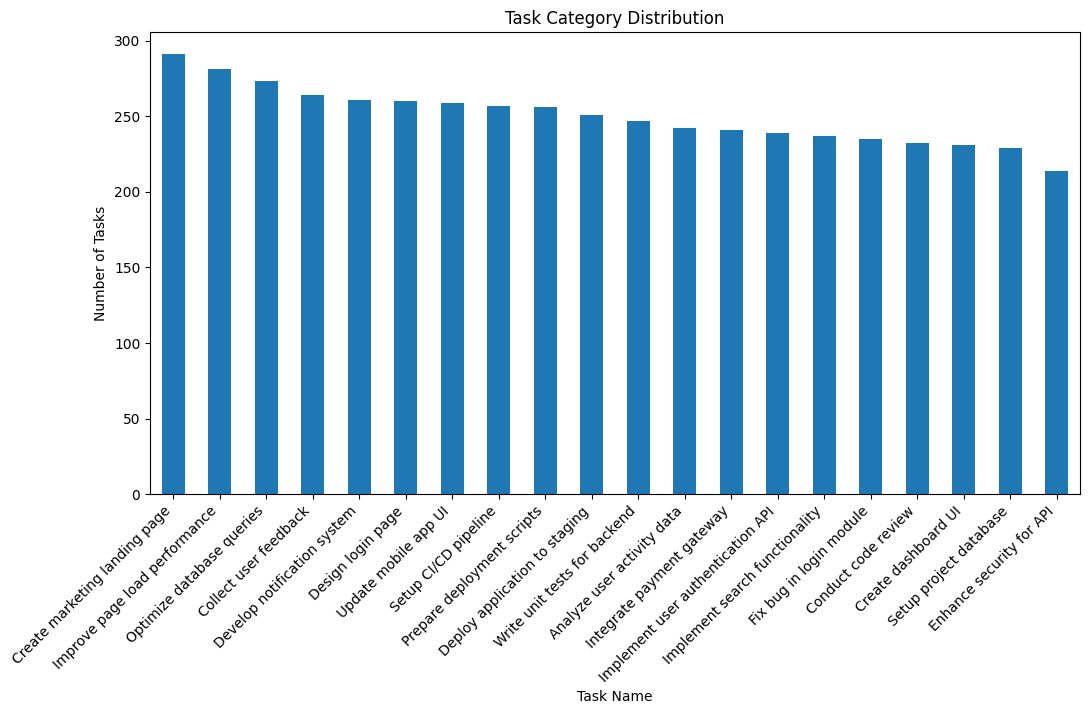

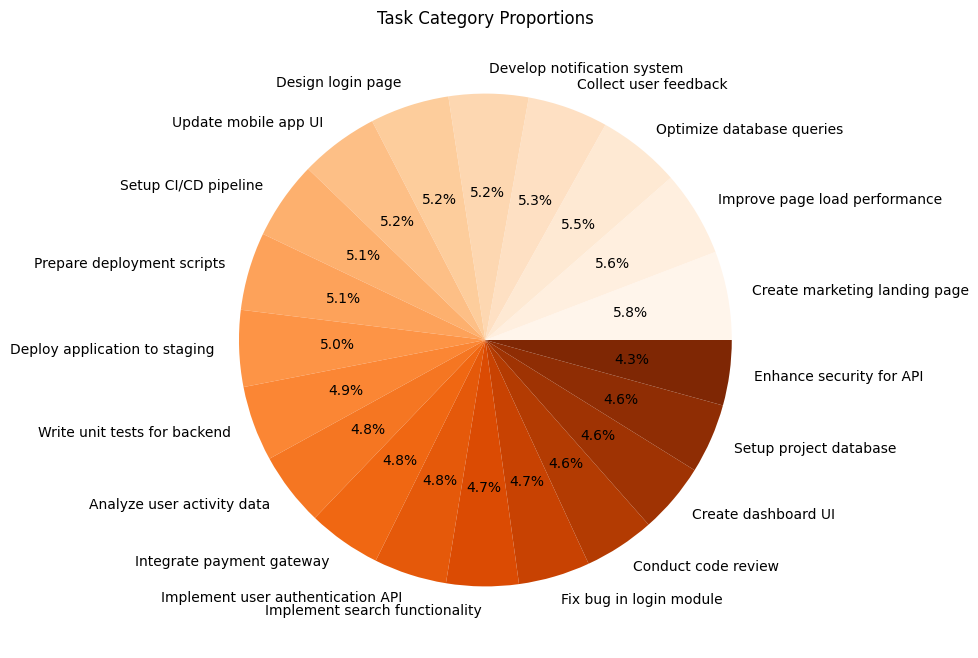

In [6]:
#Task Name Analysis-

plt.figure(figsize=(12,6))
df['task_name'].value_counts().plot(kind='bar')
plt.title("Task Category Distribution")
plt.ylabel("Number of Tasks")
plt.xlabel("Task Name")
plt.xticks(rotation=45, ha='right')
plt.show()

# Pie chart (corrected labels and colors)
counts = df['task_name'].value_counts()
labels = counts.index
colors = plt.cm.Oranges(np.linspace(0, 1, len(counts)))
plt.figure(figsize=(12,8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title("Task Category Proportions")
plt.show()

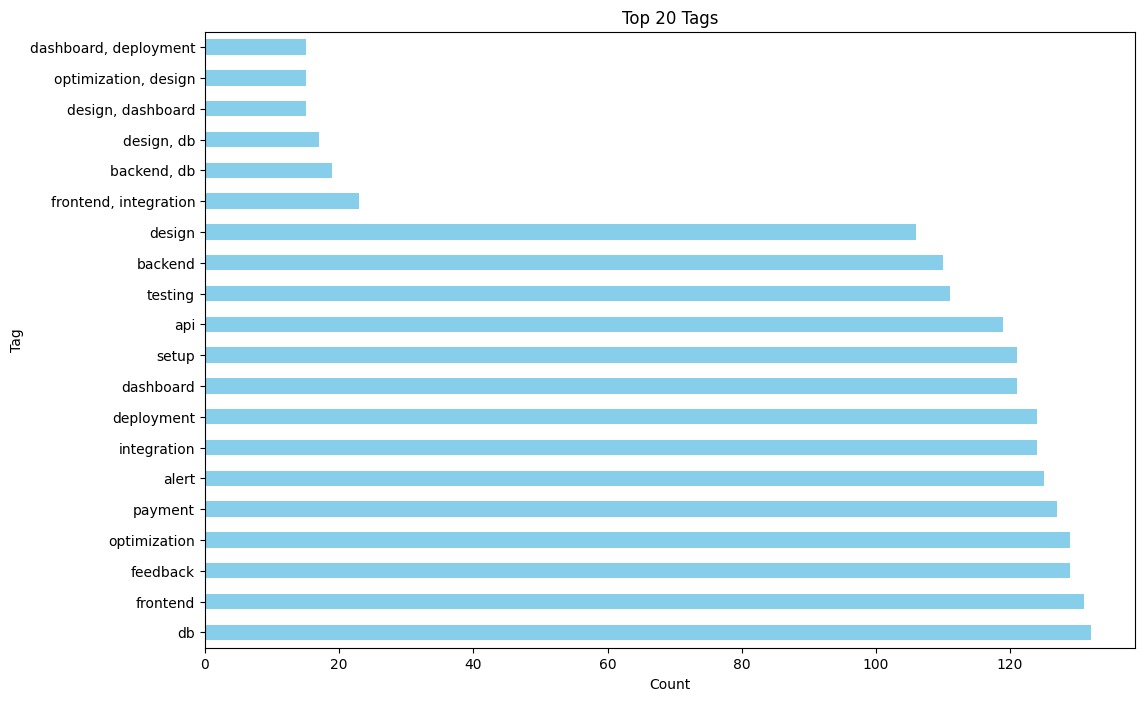

In [7]:
#Tag Analysis
if 'tags' in df.columns:
    plt.figure(figsize=(12,8))
    df['tags'].value_counts().head(20).plot(kind='barh', color='skyblue')
    plt.title("Top 20 Tags")
    plt.xlabel("Count")
    plt.ylabel("Tag")
    plt.show()

In [8]:
df['created_date'] = pd.to_datetime(df['created_date'], dayfirst=True)
df['due_date'] = pd.to_datetime(df['due_date'], dayfirst=True)
df['days_until_due'] = (df['due_date'] - df['created_date']).dt.days

In [9]:
nlp = spacy.load("en_core_web_sm")

def clean_and_lemmatize(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.lemma_)>2]
    return " ".join(tokens)

df['combined_text'] = (df['task_name'] + " " + df['department'] + " " + df['tags']).apply(clean_and_lemmatize)

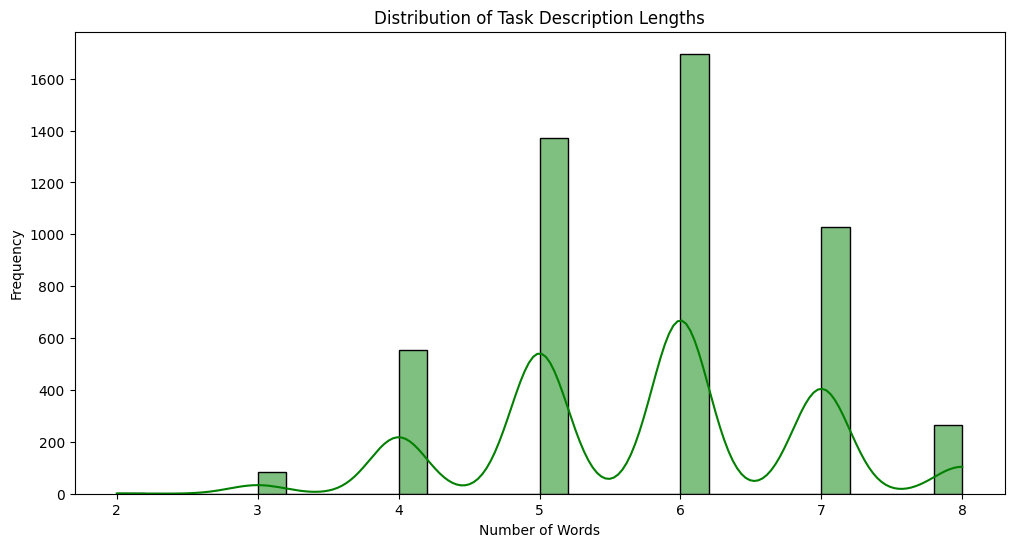

In [10]:
#Text Length Analysis
df['task_length'] = df['combined_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12,6))
sns.histplot(df['task_length'], bins=30, kde=True, color='green')
plt.title("Distribution of Task Description Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

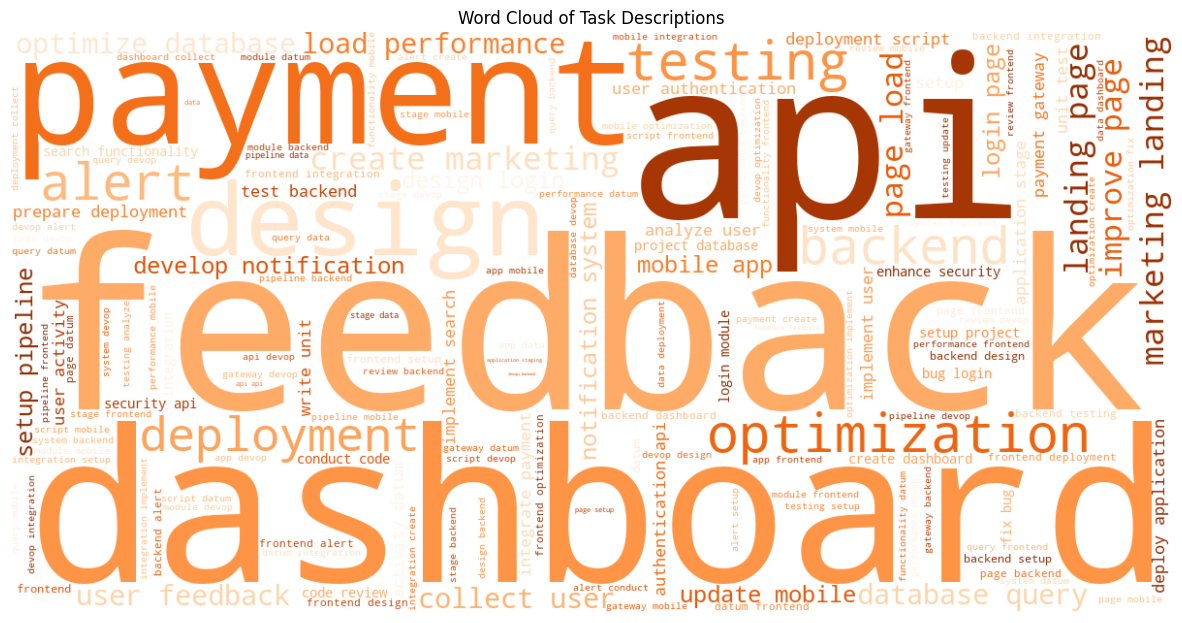

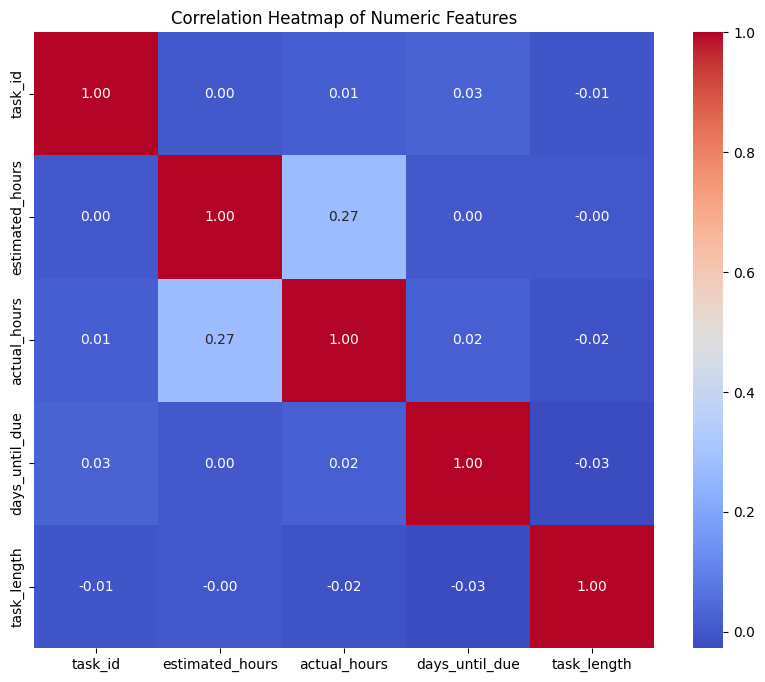

In [11]:
from wordcloud import WordCloud

all_text = " ".join(df['combined_text'])
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='Oranges').generate(all_text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Task Descriptions")
plt.show()


#Optional: Correlation for numeric features
numeric_cols = df.select_dtypes(include=np.number).columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

In [12]:
task_le = LabelEncoder()
df['task_label'] = task_le.fit_transform(df['task_name'])

priority_le = LabelEncoder()
df['priority_label'] = priority_le.fit_transform(df['priority'])

user_le = LabelEncoder()
df['user_label'] = user_le.fit_transform(df['assigned_to'])

In [13]:
# TF-IDF Features
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df['combined_text'])

In [14]:
# # task classification

y_taskname = df['task_label']

# Split data
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_text, y_taskname, test_size=0.2, random_state=42, stratify=y_taskname
)

print(
    f"Taskname Model: Training: {X_train_t.shape[0]} samples, Testing: {X_test_t.shape[0]} samples"
)

Taskname Model: Training: 4000 samples, Testing: 1000 samples


Naive Bayes (Task Name)
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000



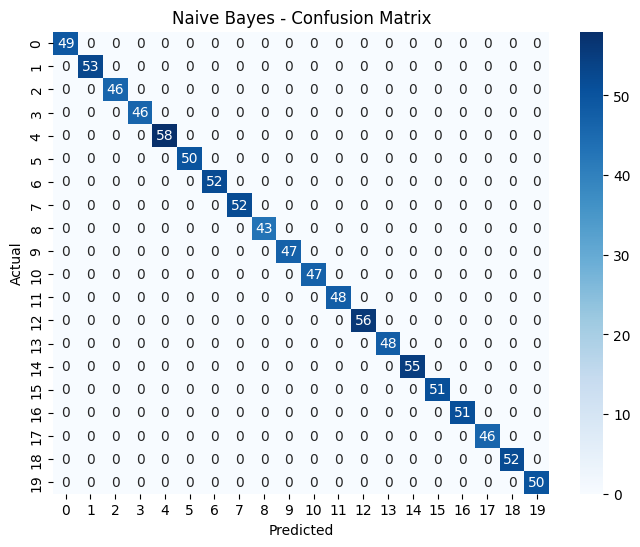

In [15]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_t, y_train_t)
y_pred_nb = nb_model.predict(X_test_t)

print("Naive Bayes (Task Name)")
print(f"Accuracy : {accuracy_score(y_test_t, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test_t, y_pred_nb, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_test_t, y_pred_nb, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_test_t, y_pred_nb, average='weighted'):.4f}\n")

#confusion matrix
cm_nb = confusion_matrix(y_test_t, y_pred_nb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM 
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000



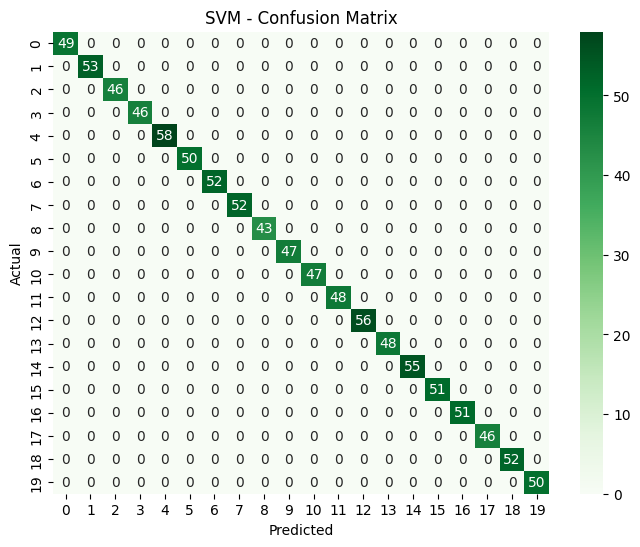

In [16]:
#Support Vector Machine (Linear)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_t, y_train_t)
y_pred_svm = svm_model.predict(X_test_t)

print("SVM ")
print(f"Accuracy : {accuracy_score(y_test_t, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test_t, y_pred_svm, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_test_t, y_pred_svm, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_test_t, y_pred_svm, average='weighted'):.4f}\n")

#confusion matrix
cm_svm = confusion_matrix(y_test_t, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens")
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
new_task = "Deploy the application to the staging environment to test its functionality, performance, and integration in a production-like setting before the final release"

new_task_cleaned = clean_and_lemmatize(new_task)
print(f"Cleaned text: {new_task_cleaned}")

new_task_tfidf = tfidf.transform([new_task_cleaned])

Cleaned text: deploy application staging environment test functionality performance integration production like set final release


In [18]:
# Using Naive Bayes
pred_nb = nb_model.predict(new_task_tfidf)
pred_task_nb = task_le.inverse_transform(pred_nb)
print(f"Naive Bayes Prediction: {pred_task_nb[0]}")

# Using SVM
pred_svm = svm_model.predict(new_task_tfidf)
pred_task_svm = task_le.inverse_transform(pred_svm)
print(f"SVM Prediction: {pred_task_svm[0]}")

Naive Bayes Prediction: Deploy application to staging
SVM Prediction: Deploy application to staging


In [19]:
# Priority Prediction Features

from scipy.sparse import hstack, csr_matrix

numeric_features = df[['estimated_hours', 'actual_hours', 'days_until_due']].values
X_priority = hstack([X_text, csr_matrix(numeric_features)])
y_priority = df['priority_label']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_priority, y_priority, test_size=0.2, random_state=42, stratify=y_priority)


print(
    f"Priority Prediction Model: Training: {X_train_p.shape[0]} samples, Testing: {X_test_p.shape[0]} samples"
)

Priority Prediction Model: Training: 4000 samples, Testing: 1000 samples


In [20]:
#  Workload Balancing Heuristic

print("\nImplementing Workload Balancing Logic (Heuristic)...")

workload_map_final = df[['assigned_to', 'department', 'actual_hours']].drop_duplicates(subset=['assigned_to'])
workload_dict = workload_map_final.set_index('assigned_to').to_dict('index')

def balance_workload_heuristic(model_prediction_label, department_of_task_label):
    dept_users = [
        user for user, data in workload_dict.items()
        if data['department'] == department_of_task_label and 'actual_hours' in data
    ]
    if not dept_users:
        return model_prediction_label

    least_loaded_user = min(dept_users, key=lambda user: workload_dict[user]['actual_hours'])
    highest_workload = max(workload_dict[user]['actual_hours'] for user in dept_users)
    predicted_workload = workload_dict.get(model_prediction_label, {}).get('actual_hours', 0)

    if (predicted_workload > 0 and
        (predicted_workload >= highest_workload * 0.9) and
        (model_prediction_label != least_loaded_user)):
        print(f"Heuristic Re-route: {model_prediction_label} → {least_loaded_user} in {department_of_task_label}")
        return least_loaded_user
    return model_prediction_label

df['final_assigned_to'] = df.apply(
    lambda row: balance_workload_heuristic(row['assigned_to'], row['department']),
    axis=1
)


print(" Workload Balancing Heuristic integrated.")


Implementing Workload Balancing Logic (Heuristic)...
Heuristic Re-route: Hannah → Grace in UI/UX
Heuristic Re-route: David → Eve in Backend
Heuristic Re-route: David → Eve in Backend
Heuristic Re-route: Hannah → Alice in QA
Heuristic Re-route: David → Eve in Backend
Heuristic Re-route: Eve → Alice in QA
Heuristic Re-route: David → Eve in Backend
Heuristic Re-route: Carol → Alice in QA
Heuristic Re-route: David → Grace in UI/UX
Heuristic Re-route: Eve → Grace in UI/UX
Heuristic Re-route: Eve → Bob in Data
Heuristic Re-route: Frank → Grace in UI/UX
Heuristic Re-route: Hannah → Alice in QA
Heuristic Re-route: Eve → Grace in UI/UX
Heuristic Re-route: Bob → Alice in QA
Heuristic Re-route: Hannah → Alice in QA
Heuristic Re-route: David → Eve in Backend
Heuristic Re-route: Alice → Bob in Data
Heuristic Re-route: Hannah → Bob in Data
Heuristic Re-route: Bob → Eve in Backend
Heuristic Re-route: Grace → Eve in Backend
Heuristic Re-route: Alice → Eve in Backend
Heuristic Re-route: Eve → Grace in

In [21]:
def assign_new_task(task_name, task_tags, department_of_task):
    
    # Preprocess text
    combined_text = clean_and_lemmatize(task_name + " " + task_tags)
    
    # Convert to TF-IDF features
    X_new = tfidf.transform([combined_text])
    
    # Predict task type (category)
    predicted_task_label = nb_model.predict(X_new)[0]  # or best_svm
    
    # Predict priority using the tuned Random Forest
    predicted_priority_label = best_rf_priority.predict(X_new)[0]
    predicted_priority = le_priority.inverse_transform([predicted_priority_label])[0]
    
    # Initial user assignment (placeholder for now)
    initial_user = ""
    
    # Apply workload balancing heuristic
    final_user = balance_workload_heuristic(initial_user, department_of_task)
    
    return {
        "predicted_task_type": predicted_task_label,
        "predicted_priority": predicted_priority,
        "final_assigned_user": final_user
    }

In [22]:
# User Assignment Features

dept_dummies = pd.get_dummies(df['department'])
X_user_base = hstack([
    X_text, 
    csr_matrix(numeric_features), 
    csr_matrix(dept_dummies.values.astype(float)), 
    csr_matrix(df[['task_label','priority_label']].values)
])
y_user = df['user_label']

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_user_base, y_user, test_size=0.2, random_state=42, stratify=y_user)

print(
    f"User Prediction Model: Training: {X_train_p.shape[0]} samples, Testing: {X_test_p.shape[0]} samples"
)

User Prediction Model: Training: 4000 samples, Testing: 1000 samples


In [23]:
# GridSearchCV Hyperparameter Tuning
from sklearn.model_selection import train_test_split, GridSearchCV
# Priority Random Forest 
rf_priority = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf_priority, rf_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)
rf_grid.fit(X_train_p, y_train_p)
best_rf_priority = rf_grid.best_estimator_
print("Best Priority RF Params:", rf_grid.best_params_)
print("Priority Model Classification Report:")
print(classification_report(y_test_p, best_rf_priority.predict(X_test_p), target_names=priority_le.classes_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Priority RF Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Priority Model Classification Report:
              precision    recall  f1-score   support

        High       0.28      0.24      0.26       298
         Low       0.24      0.13      0.17       198
      Medium       0.51      0.64      0.57       504

    accuracy                           0.42      1000
   macro avg       0.34      0.34      0.33      1000
weighted avg       0.39      0.42      0.40      1000



In [24]:
# ---- User Assignment Random Forest ----
rf_user = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_user_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
user_grid = GridSearchCV(rf_user, rf_user_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)
user_grid.fit(X_train_u, y_train_u)
best_rf_user = user_grid.best_estimator_
print("Best User RF Params:", user_grid.best_params_)
print("User Assignment Classification Report:")
print(classification_report(y_test_u, best_rf_user.predict(X_test_u), target_names=user_le.classes_))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best User RF Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
User Assignment Classification Report:
              precision    recall  f1-score   support

       Alice       0.09      0.07      0.08       118
         Bob       0.10      0.11      0.10       120
       Carol       0.08      0.08      0.08       125
       David       0.13      0.13      0.13       126
         Eve       0.13      0.16      0.14       134
       Frank       0.17      0.17      0.17       130
       Grace       0.11      0.12      0.11       124
      Hannah       0.08      0.07      0.08       123

    accuracy                           0.11      1000
   macro avg       0.11      0.11      0.11      1000
weighted avg       0.11      0.11      0.11      1000



In [25]:
# ---- Task Type SVM ----
svm = SVC(kernel='linear', probability=True, random_state=42)
svm_param_grid = {'C': [0.1, 1, 10]}
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)
svm_grid.fit(X_text, df['task_label'])
best_svm = svm_grid.best_estimator_
print("Best Task Type SVM Params:", svm_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Task Type SVM Params: {'C': 0.1}


In [26]:
# End-to-End Assignment Function

def assign_task_production(task_name, task_tags, department, estimated_hours=0, actual_hours=0, days_until_due=0):
    combined = clean_and_lemmatize(task_name + " " + task_tags)
    X_new_text = tfidf.transform([combined])
    
    # Task type
    task_label = best_svm.predict(X_new_text)[0]
    task_name_pred = task_le.inverse_transform([task_label])[0]
    
    # Priority
    X_new_priority = hstack([
        X_new_text, 
        csr_matrix(np.array([[estimated_hours, actual_hours, days_until_due]]))
    ])
    priority_label = best_rf_priority.predict(X_new_priority)[0]
    priority_pred = priority_le.inverse_transform([priority_label])[0]
    
    # User assignment
    dept_vec = pd.get_dummies([department]).reindex(columns=dept_dummies.columns, fill_value=0)
    X_new_user = hstack([
        X_new_text,
        csr_matrix(np.array([[estimated_hours, actual_hours, days_until_due]])),
        csr_matrix(dept_vec.values.astype(float)),
        csr_matrix(np.array([[task_label, priority_label]]))
    ])
    user_label = best_rf_user.predict(X_new_user)[0]
    assigned_user = user_le.inverse_transform([user_label])[0]
    
    return {
        "task_name": task_name_pred,
        "priority": priority_pred,
        "assigned_user": assigned_user
    }

In [27]:
# Test Example

new_tasks = [
    {"task_name": "Create landing page", "task_tags": "frontend, deployment", "department": "Backend", "estimated_hours":5, "actual_hours":0, "days_until_due":7},
    {"task_name": "Update server configuration", "task_tags": "performance, server", "department": "IT", "estimated_hours":3, "actual_hours":0, "days_until_due":3}
]

for task in new_tasks:
    result = assign_task_production(**task)
    print(result)

{'task_name': 'Create marketing landing page', 'priority': 'Medium', 'assigned_user': 'Bob'}
{'task_name': 'Update mobile app UI', 'priority': 'Medium', 'assigned_user': 'Grace'}


In [28]:
#Save Models
# ---------------------------
joblib.dump(best_svm, "task_type_model.pkl")
joblib.dump(best_rf_priority, "priority_model.pkl")
joblib.dump(best_rf_user, "user_assignment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(task_le, "task_le.pkl")
joblib.dump(priority_le, "priority_le.pkl")
joblib.dump(user_le, "user_le.pkl")
joblib.dump(list(dept_dummies.columns), "dept_dummies.pkl")

['dept_dummies.pkl']